In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../..')

%matplotlib inline
sns.set()

In [2]:
from collections import namedtuple

Y = namedtuple('Y', ['mu', 'std', 'c_l', 'c_u'])
Keys = ['loss', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape']

In [3]:
import glob

In [4]:
dataset = 'btc_30m_close.csv'

In [5]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')

In [6]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')[0]
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')[0]
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')[0]
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')[0]
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')[0]

In [7]:
def get_ci(x, z=1.96):
    if x.ndim == 2:
        n = x.shape[1]
        mu = x.mean(axis=1)
        std = x.std(axis=1)
    else:
        n = x.shape[0]
        mu = x.mean()
        std = x.std()
        
    c_l, c_u = (mu - z * std/np.sqrt(n), mu + z * std/np.sqrt(n))
    return mu, std, c_l, c_u

In [8]:
def get_train_results(path, key='mae', z=1.96):
    return Y(*get_ci(pd.concat([pd.read_csv(x+'/train/results.csv')[key] for x in path], axis=1), z=z))

In [9]:
df_no_kaf = pd.read_csv(no_kaf + '/train/results.csv')
df_kaf_time = pd.read_csv(kaf_time + '/train/results.csv')
df_kaf_input = pd.read_csv(kaf_input + '/train/results.csv')
df_kaf_dual = pd.read_csv(kaf_dual + '/train/results.csv')
df_seq2seq = pd.read_csv(seq2seq + '/train/results.csv')

In [10]:
def smooth(x,w=0.5):
    p = x[0]
    xs = []
    for d in x:
        p = p * w + (1-w) * d
        xs.append(p)
    return np.array(xs)

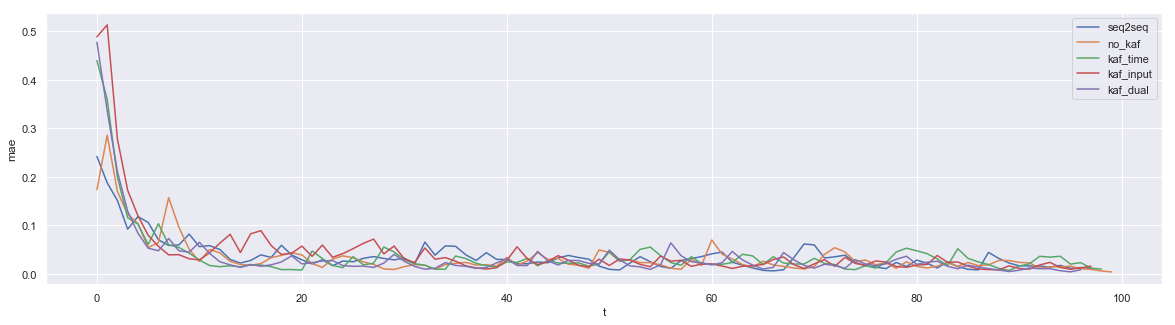

In [11]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

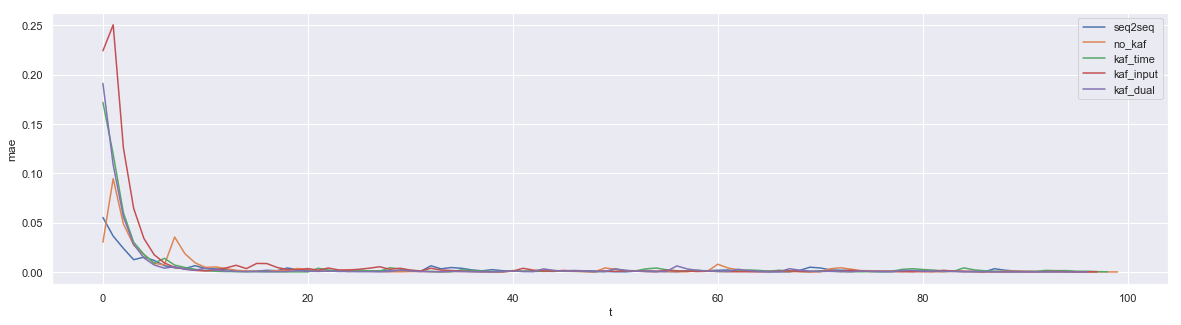

In [12]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.mse.values))
ax.plot(smooth(df_no_kaf.mse.values))
ax.plot(smooth(df_kaf_time.mse.values))
ax.plot(smooth(df_kaf_input.mse.values))
ax.plot(smooth(df_kaf_dual.mse.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [13]:
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))

In [19]:
np.sqrt(df_seq2seq.mean(axis=0).mse)

0.04857453693648086

In [14]:
# no reg
rows = ['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual']

table = pd.concat([df_seq2seq.mean(axis=0),
                   df_no_kaf.mean(axis=0), 
                   df_kaf_time.mean(axis=0), 
                   df_kaf_input.mean(axis=0), 
                   df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.034722,0.001516,2.101043,0.002359,0.033206,0.069192,0.033206,8.812321
no_kaf,0.032444,0.000000,4.109165,0.003720,0.032444,0.068365,0.032444,22.175550
kaf_time,0.033777,0.001685,4.371209,0.003688,0.032093,0.068290,0.032093,7.251746
kaf_input,0.040083,0.003034,4.174733,0.006524,0.037049,0.079149,0.037049,10.295585
kaf_dual,0.030192,0.004445,3.452023,0.003120,0.025747,0.057693,0.025747,7.712679


In [71]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.003673,0.000235,0.103390,0.000639,0.003535,0.009637,0.003535,1.407046
no_kaf,0.005086,0.000000,0.155661,0.001726,0.005086,0.012379,0.005086,8.186072
kaf_time,0.005469,0.000454,0.156539,0.001857,0.005164,0.014790,0.005164,1.159818
kaf_input,0.007426,0.000250,0.156947,0.003604,0.007251,0.019363,0.007251,3.447467
kaf_dual,0.005482,0.000734,0.141960,0.001985,0.005002,0.015609,0.005002,1.789770


In [72]:
table.index

Index(['loss', 'reg', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape'], dtype='object')

In [73]:
header = table.index.tolist()

In [74]:
df_no_kaf = pd.read_csv(no_kaf + '/test/results.csv', header=None)
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))
df_no_kaf.columns = header

In [75]:
df_seq2seq = pd.read_csv(seq2seq+ '/test/results.csv', names=header)
df_kaf_time = pd.read_csv(kaf_time + '/test/results.csv', names=header)
df_kaf_input = pd.read_csv(kaf_input + '/test/results.csv', names=header)
df_kaf_dual = pd.read_csv(kaf_dual+ '/test/results.csv', names=header)

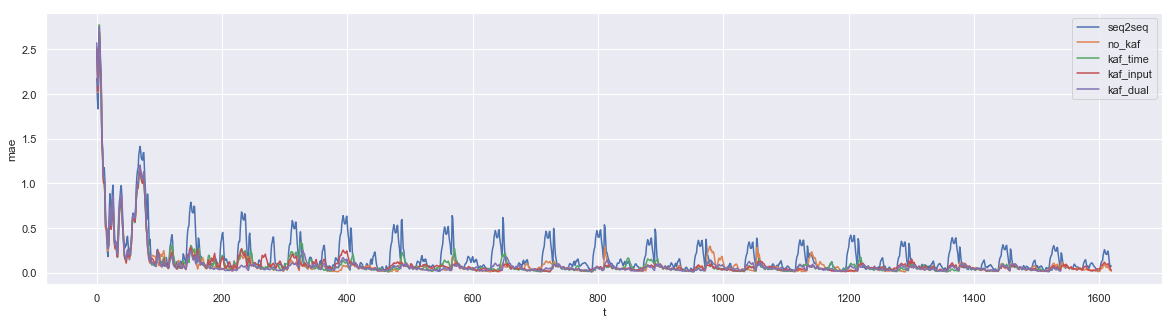

In [76]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [77]:
table = pd.concat([
                    df_seq2seq.mean(axis=0),
                    df_no_kaf.mean(axis=0), 
                    df_kaf_time.mean(axis=0), 
                    df_kaf_input.mean(axis=0), 
                    df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

In [78]:
# no reg
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.182901,0.002047,2.212911,0.103289,0.180854,0.266121,0.180854,56.894069
no_kaf,0.096161,0.000000,3.371535,0.056179,0.096161,0.154262,0.096161,30.158698
kaf_time,0.103722,0.002358,3.607303,0.058609,0.101364,0.160015,0.101364,30.280524
kaf_input,0.101721,0.003348,3.198134,0.055094,0.098373,0.160248,0.098373,31.426644
kaf_dual,0.096498,0.005109,2.310693,0.057282,0.091389,0.146357,0.091389,26.373913


In [79]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.006393,0.000047,0.028616,0.010615,0.006389,0.008436,0.006389,2.667058
no_kaf,0.005255,0.000000,0.059707,0.010563,0.005255,0.007707,0.005255,1.245086
kaf_time,0.005573,0.000152,0.068560,0.011279,0.005470,0.007618,0.005470,1.192014
kaf_input,0.005209,0.000077,0.054771,0.010413,0.005156,0.007503,0.005156,1.240016
kaf_dual,0.005665,0.000236,0.045345,0.011286,0.005503,0.008109,0.005503,0.964166


In [80]:
def last_path(base_path):
    paths = glob.glob(base_path + '/report/*.csv')
    idxs = list(map(lambda x: int(x.split('/')[-1].split('_')[0]), paths))
    idx = max(idxs)
    paths
    return base_path + '/report/' + ''.join([str(idx), '_', 'report.csv'])

In [81]:
df_no_kaf = pd.read_csv(last_path(no_kaf), index_col=0)
# df_dense = pd.read_csv(last_path(dense), index_col=0)
df_seq2seq = pd.read_csv(last_path(seq2seq), index_col=0)
df_kaf_time = pd.read_csv(last_path(kaf_time), index_col=0)
df_kaf_input = pd.read_csv(last_path(kaf_input), index_col=0)
df_kaf_dual = pd.read_csv(last_path(kaf_dual), index_col=0)

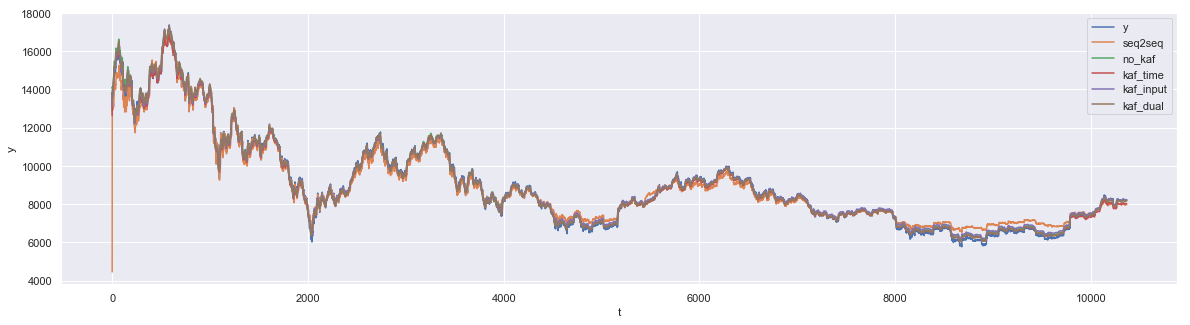

In [82]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(df_no_kaf.y.values)
ax.plot(df_seq2seq.y_hat.values)
ax.plot(df_no_kaf.y_hat.values)
# ax.plot(df_dense.y_hat.values)
ax.plot(df_kaf_time.y_hat.values)
ax.plot(df_kaf_input.y_hat.values)
ax.plot(df_kaf_dual.y_hat.values)
plt.ylabel('y')
plt.xlabel('t')
plt.legend(['y',
            'seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [83]:
from ntsa.utils.misc import regr_metrics

In [84]:
y = df_no_kaf.y.values
y_seq2seq = df_seq2seq.y_hat.values
y_no_kaf = df_no_kaf.y_hat.values
y_kaf_time = df_kaf_time.y_hat.values
y_kaf_input = df_kaf_input.y_hat.values
y_kaf_dual = df_kaf_dual.y_hat.values

In [85]:
metrics = [
list(regr_metrics(y, y_seq2seq).values()),
list(regr_metrics(y, y_no_kaf).values()),
list(regr_metrics(y, y_kaf_time).values()),
list(regr_metrics(y, y_kaf_input).values()),
list(regr_metrics(y, y_kaf_dual).values())
]

In [86]:
pd.DataFrame(np.array(metrics), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape', 'mape'])

,mse,mae,smape,mape
seq2seq,92638.257615,219.434531,0.027194,2.683669
no_kaf,22787.196732,110.327439,0.012749,1.267225
time,18499.744265,102.248994,0.011648,1.164233
input,29187.861023,131.547293,0.015921,1.575076
dual,20173.768906,97.681391,0.010756,1.071532
